In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [2]:
beatles_5_5 = nx.read_edgelist("./SAN-beatles-5-5-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])
beatles_5_10 = nx.read_edgelist("./SAN-beatles-5-10-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])
beatles_10_5 = nx.read_edgelist("./SAN-beatles-10-5-EL.csv", delimiter="\t", nodetype=str, create_using=nx.DiGraph(), data=[('rank', float),])


In [3]:
print(beatles_5_5.number_of_nodes())
print(beatles_5_5.number_of_edges())
print(beatles_5_10.number_of_nodes())
print(beatles_5_10.number_of_edges())
print(beatles_10_5.number_of_nodes())
print(beatles_10_5.number_of_edges())

372
1025
2352
7625
1663
7000


In [4]:
beatles_5_5_na = pd.read_csv("./SAN-beatles-5-5-NA.csv", delimiter="\t")
# beatles_5_5_na.followers = beatles_5_5_na.followers.astype(int)

beatles_5_10_na = pd.read_csv("./SAN-beatles-5-10-NA.csv", delimiter="\t")
# beatles_5_10_na.followers = beatles_5_10_na.followers.astype(int)

beatles_10_5_na = pd.read_csv("./SAN-beatles-10-5-NA.csv", delimiter="\t")
# beatles_10_5_na.followers = beatles_10_5_na.followers.astype(int)

In [5]:
labels = beatles_5_5_na.columns

In [6]:
# Assign node atrributes to nodes in the graph
iter = 0

for ID in beatles_5_5_na["id"]:

    for feature in labels:

        cat = beatles_5_5_na[feature][iter]
        
        if type(cat) is str:
            beatles_5_5.node[ID][feature] = cat
            
        if not type(cat) is float or not math.isnan(cat):
            beatles_5_5.node[ID][feature] = cat
        
    iter += 1

In [7]:
# Remove nodes created from edges leading out of the graph (next level of depth)
found = False
total = 0
for ID in beatles_5_5.nodes():
    found = False
    for match in beatles_5_5_na["id"]:
        if match == ID:
            found = True
    if not found:
        beatles_5_5.remove_node(ID)
        total += 1

print(total)

167


In [8]:
# Assign node atrributes to nodes in the graph
iter = 0

for ID in beatles_5_10_na["id"]:

    for feature in labels:

        cat = beatles_5_10_na[feature][iter]
        
        if type(cat) is str:
            beatles_5_10.node[ID][feature] = cat
            
        if not type(cat) is float or not math.isnan(cat):
            beatles_5_10.node[ID][feature] = cat
        
    iter += 1

In [9]:
# Remove nodes created from edges leading out of the graph (next level of depth)
found = False
total = 0
for ID in beatles_5_10.nodes():
    found = False
    for match in beatles_5_10_na["id"]:
        if match == ID:
            found = True
    if not found:
        beatles_5_10.remove_node(ID)
        total += 1

print(total)

0


In [10]:
# Assign node atrributes to nodes in the graph
iter = 0

for ID in beatles_10_5_na["id"]:

    for feature in labels:

        cat = beatles_10_5_na[feature][iter]
        
        if type(cat) is str:
            beatles_10_5.node[ID][feature] = cat
            
        if not type(cat) is float or not math.isnan(cat):
            beatles_10_5.node[ID][feature] = cat
        
    iter += 1

In [11]:
# Remove nodes created from edges leading out of the graph (next level of depth)
found = False
total = 0
for ID in beatles_10_5.nodes():
    found = False
    for match in beatles_10_5_na["id"]:
        if match == ID:
            found = True
    if not found:
        beatles_10_5.remove_node(ID)
        total += 1

print(total)

0


## In Degree Analysis

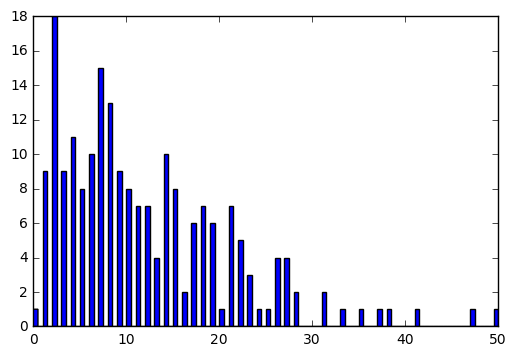

In [12]:
in_degrees_beatles_5_5 = beatles_5_5.in_degree(weight="rank")

in_degrees_beatles_5_5_dist = []
for v in in_degrees_beatles_5_5.values():
    in_degrees_beatles_5_5_dist.append(v)
    
_ = plt.hist(in_degrees_beatles_5_5_dist, bins=100)

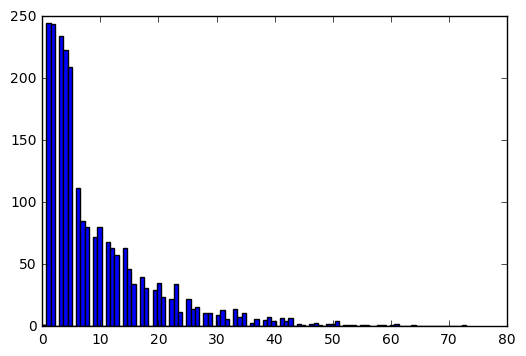

In [13]:
in_degrees_beatles_5_10 = beatles_5_10.in_degree(weight="rank")

in_degrees_beatles_5_10_dist = []
for v in in_degrees_beatles_5_10.values():
    in_degrees_beatles_5_10_dist.append(v)
    
_ = plt.hist(in_degrees_beatles_5_10_dist, bins=100)

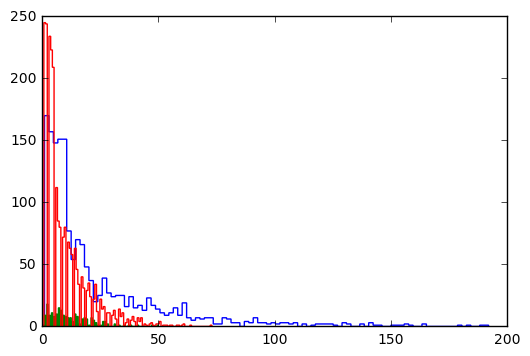

In [14]:
in_degrees_beatles_10_5 = beatles_10_5.in_degree(weight="rank")

in_degrees_beatles_10_5_dist = []
for v in in_degrees_beatles_10_5.values():
    in_degrees_beatles_10_5_dist.append(v)
    
_ = plt.hist(in_degrees_beatles_10_5_dist, bins=100, histtype='step')
_ = plt.hist(in_degrees_beatles_5_5_dist, bins=100, histtype='step')
_ = plt.hist(in_degrees_beatles_5_10_dist, bins=100, histtype='step')

In [27]:
pop = []
fol = []
num = 0
for k,v in in_degrees_beatles_5_5.items():
    if v > 40:
#         print(beatles_5_5.node[k])
#         print("\n")
        pop.append(beatles_5_5.node[k]["popularity"])
        fol.append(beatles_5_5.node[k]["followers"])
        num += 1
for k,v in in_degrees_beatles_5_10.items():
    if v > 50:
#         print(beatles_5_10.node[k])
#         print("\n")
        pop.append(beatles_5_10.node[k]["popularity"])
        fol.append(beatles_5_10.node[k]["followers"])
        num += 1
for k,v in in_degrees_beatles_10_5.items():
    if v > 150:
#         print(beatles_10_5.node[k])
#         print("\n")
        pop.append(beatles_10_5.node[k]["popularity"])
        fol.append(beatles_10_5.node[k]["followers"])
        num += 1

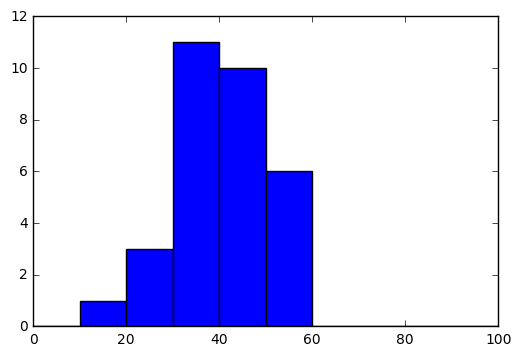

In [40]:
_ = plt.hist(pop, range=(0,100))

Observation: popularity doesn't really corres

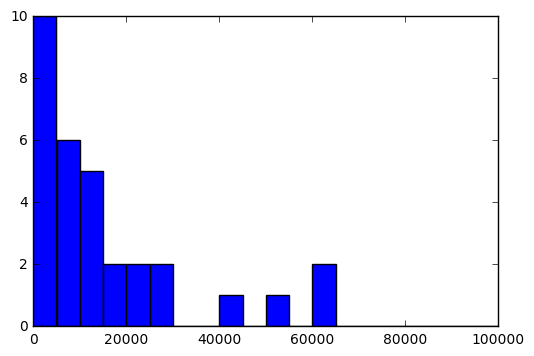

In [39]:
 _ = plt.hist(fol, range=(0, 100000), bins=20)

In [16]:
genres_b_5_5 = []

def addGenre(genre):
    if type(genre) is str:
        genres_b_5_5.append(genre)
beatles_5_10_na.genre1.apply(addGenre)
beatles_5_10_na.genre2.apply(addGenre)
beatles_5_10_na.genre3.apply(addGenre)
beatles_5_10_na.genre4.apply(addGenre)
beatles_5_10_na.genre5.apply(addGenre)

random.shuffle(genres_b_5_5)

In [17]:
beatles_10_5?